In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import warnings
import scipy
from scipy.sparse import csr_matrix
import anndata as ad
from pathlib import Path


sc.set_figure_params(dpi=150)
sc.settings.verbosity = 3
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
import os
import glob

version = "v2"

ROOT_FOLDER = f"/n/groups/kirschner/xenopus/old_atlas/inDropest_{version}/"
# DATA_DIR = "/n/groups/kirschner/xenopus/old_atlas"

# ROOT_FOLDER = f"/n/scratch/users/k/ksp503/results/xenopus/old_atlas/inDropest_{version}_cutadapt/results"
# DATA_DIR = "/n/groups/kirschner/xenopus/old_atlas"

# genome_annotation = "Xentr10.0_braker3_run1_fixed"
# genome_annotation = "Xentr10.7"
# input_subfolder = f"{genome_annotation}_94_merged"

re_DATA_DIR = ROOT_FOLDER # os.path.join(ROOT_FOLDER, input_subfolder)

In [3]:
os.environ['R_HOME'] = '/home/ksp503/.conda/envs/xenopus/lib/R'

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

/tmp/ipykernel_4530/3588234559.py:4: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
NF_stage = "S8"

# Reading intron, exon matrices

In [5]:
def get_adata(name, results_dir):
    
    mtx_fp = os.path.join(results_dir, f"{name}.mtx")
    gene_names_fp = os.path.join(results_dir, f"{name}.genes.tsv")
    cell_barcodes_fp = os.path.join(results_dir, f"{name}.cells.tsv")
    
    adata = sc.read_mtx(mtx_fp, dtype='float32').transpose()

    gene_names = [l.strip() for l in open(gene_names_fp).readlines()]
    cell_barcodes = [l.strip() for l in open(cell_barcodes_fp).readlines()]
    
    adata.var_names = gene_names
    adata.obs_names = cell_barcodes
    
    return adata


def adjusting_shape(adata1, adata2, debug=False):
    
    assert (adata1.obs_names == adata2.obs_names).all()
    
    adata1_in_adata2_genes_idx = adata1.var_names.isin(adata2.var_names)
    common_genes = adata1.var_names[adata1_in_adata2_genes_idx]
    
    if debug:
        print(f"common_genes: {adata1_in_adata2_genes_idx.sum()}")

    adata1_genes = adata1.var_names[~adata1_in_adata2_genes_idx]
    adata2_genes = adata2.var_names[~adata2.var_names.isin(adata1.var_names)]
    
    if debug:
        print(f"adata1_genes: {len(adata1_genes)}")
        print(f"adata2_genes: {len(adata2_genes)}")

    adata1_common_X = adata1[:, common_genes].X
    adata2_common_X = adata2[:, common_genes].X

    if debug:
        print(f"adata1_common_X: {adata1_common_X.shape}")
        print(f"adata2_common_X: {adata2_common_X.shape}")

    adata1_genes_X = adata1[:, adata1_genes].X
    adata2_genes_X = adata2[:, adata2_genes].X

    if debug:
        print(f"adata1_genes_X: {adata1_genes_X.shape}")
        print(f"adata2_genes_X: {adata2_genes_X.shape}")
    
    X1_0 = scipy.sparse.csr_matrix((adata1.shape[0], adata2_genes_X.shape[1]), dtype=np.float32)
    if debug:
        print(f"X1_0: {X1_0.shape}")

    X1 = scipy.sparse.hstack([adata1_common_X, adata1_genes_X, X1_0])
    if debug:
            print(f"X1: {X1.shape}")

    X2_0 = scipy.sparse.csr_matrix((adata1.shape[0], adata1_genes_X.shape[1]), dtype=np.float32)
    if debug:
        print(f"X2_0: {X2_0.shape}")

    X2 = scipy.sparse.hstack([adata2_common_X, X2_0, adata2_genes_X])
    if debug:
        print(f"X2: {X2.shape}")
    
    adata1_new = ad.AnnData(X1)
    adata2_new = ad.AnnData(X2)
    
    var_names = pd.concat([common_genes.to_series(), adata1_genes.to_series(), adata2_genes.to_series()])
    adata1_new.var_names = var_names
    adata1_new.obs_names = adata1.obs_names
    
    adata2_new.var_names = var_names
    adata2_new.obs_names = adata1.obs_names
    
    if debug:
        print(adata1.shape, adata2.shape, adata1_new.shape, adata2_new.shape)
        print()
        
    return adata1_new, adata2_new

In [6]:
layers = ["intron", "exon", "spanning"]

if version == "v2":
    lib_folder = os.path.join(NF_stage, "*")
else:
    lib_folder = f"{NF_stage}*"

lib_names = [os.path.basename(f) for f in glob.glob(os.path.join(ROOT_FOLDER, lib_folder))]
lib_names

adatas = []

debug = True


for lib_name in lib_names:
    if version == "v2":
        results_dir = os.path.join(ROOT_FOLDER, NF_stage, lib_name)
    else:
        results_dir = os.path.join(ROOT_FOLDER, lib_name)
    
    # lib_name = Path(results_dir).parts[-1]
    print(lib_name)
    
    adata = get_adata("cell.counts", results_dir)
    exon = get_adata("exon", results_dir)
    intron = get_adata("intron", results_dir)
    spanning = get_adata("spanning", results_dir)
    
    # if debug:
    #     print(adata[:,"XBXT10g009952"].X.sum())
    #     print(exon[:,"XBXT10g009952"].X.sum())
    #     print(intron[:,"XBXT10g009952"].X.sum())
    #     print(spanning[:,"XBXT10g009952"].X.sum())
    #     print()
    # debug=False
    adata1, exon1 = adjusting_shape(
        adata,
        exon,
        debug=debug
    )
    adata2, intron1 = adjusting_shape(
        adata1,
        intron,
        debug=debug
    )
    exon2, intron2 = adjusting_shape(
        exon1,
        intron,
        debug=debug
    )
    adata3, spanning1 = adjusting_shape(
        adata2,
        spanning,
        debug=debug
    )
    exon3, spanning2 = adjusting_shape(
        exon2,
        spanning,
        debug=debug
    )
    intron3, spanning3 = adjusting_shape(
        intron2,
        spanning,
        debug=debug
    )
    
    adata_layer_list = [intron3, exon3, spanning3]
        
    for layer, adata_layer in zip(layers, adata_layer_list):
        adata3.layers[layer] = adata_layer.X.copy()
    
    adatas.append(adata3)
    adata3.obs["lib"] = lib_name
    
    # adatas.append(adata)
    # adata.obs["lib"] = lib_name
    # libs.append(lib_name)
    
    # debug=True

SRR7061415
common_genes: 16420
adata1_genes: 4140
adata2_genes: 0
adata1_common_X: (16059, 16420)
adata2_common_X: (16059, 16420)
adata1_genes_X: (16059, 4140)
adata2_genes_X: (16059, 0)
X1_0: (16059, 0)
X1: (16059, 20560)
X2_0: (16059, 4140)
X2: (16059, 20560)
(16059, 20560) (16059, 16420) (16059, 20560) (16059, 20560)

common_genes: 17085
adata1_genes: 3475
adata2_genes: 0
adata1_common_X: (16059, 17085)
adata2_common_X: (16059, 17085)
adata1_genes_X: (16059, 3475)
adata2_genes_X: (16059, 0)
X1_0: (16059, 0)
X1: (16059, 20560)
X2_0: (16059, 3475)
X2: (16059, 20560)
(16059, 20560) (16059, 17085) (16059, 20560) (16059, 20560)

common_genes: 17085
adata1_genes: 3475
adata2_genes: 0
adata1_common_X: (16059, 17085)
adata2_common_X: (16059, 17085)
adata1_genes_X: (16059, 3475)
adata2_genes_X: (16059, 0)
X1_0: (16059, 0)
X1: (16059, 20560)
X2_0: (16059, 3475)
X2: (16059, 20560)
(16059, 20560) (16059, 17085) (16059, 20560) (16059, 20560)

common_genes: 6303
adata1_genes: 14257
adata2_genes: 

In [7]:
cell_barcodes_vs = np.zeros((len(lib_names), len(lib_names)))

for i in range(len(adatas)):
    cell_barcodes_vs[i, i] = 1
    for j in range(i):
        cell_barcodes_vs[i, j] = adatas[i].obs_names.isin(adatas[j].obs_names).sum()
        cell_barcodes_vs[j, i] = cell_barcodes_vs[i, j]
        
        cell_barcodes_vs[i, j] /= adatas[i].shape[0]
        cell_barcodes_vs[j, i] /= adatas[j].shape[0]

<Axes: >

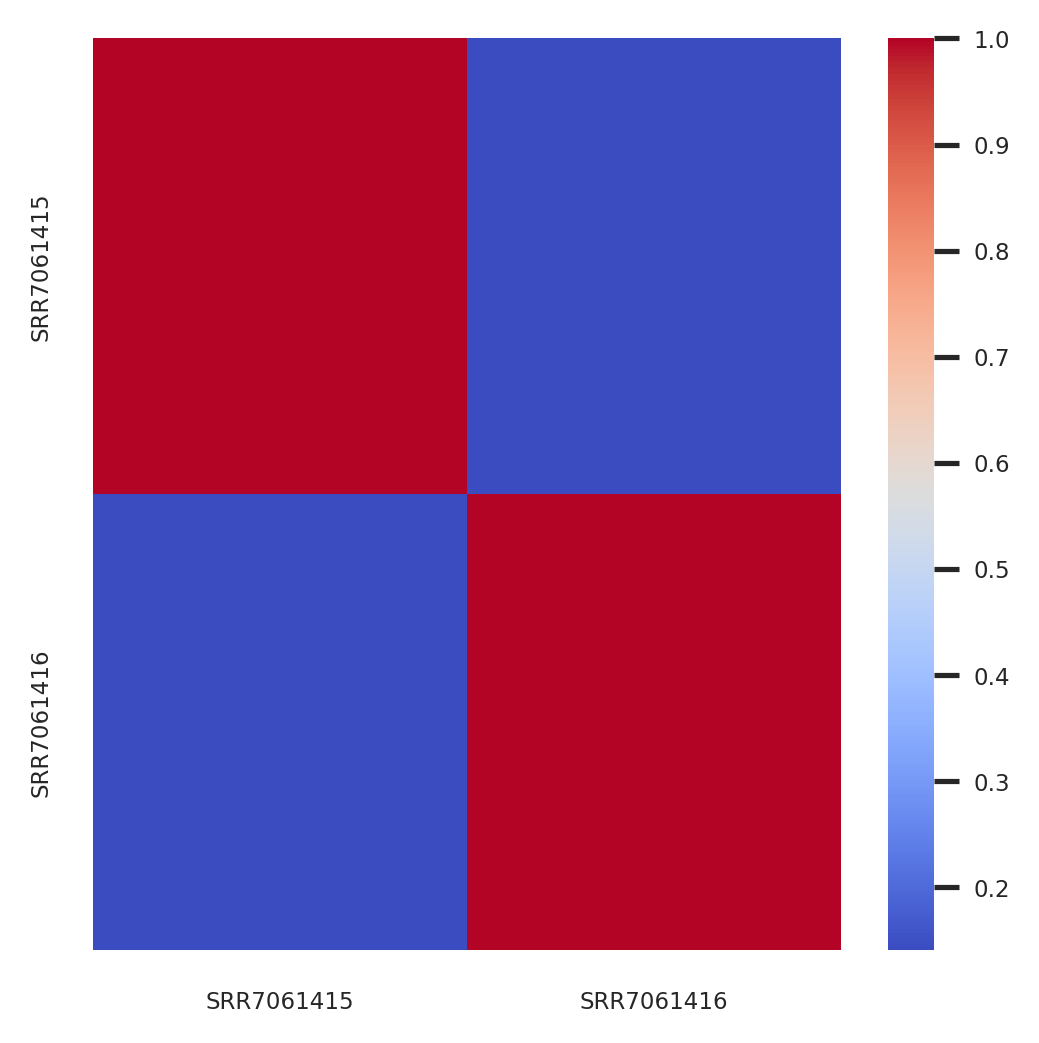

In [8]:
sns.set(font_scale=0.5)
sns.heatmap(cell_barcodes_vs, cmap="coolwarm", xticklabels=lib_names, yticklabels=lib_names)

In [9]:
sum([adatas[i].shape[0] for i in range(len(adatas))])

32224

In [10]:
adatas

[AnnData object with n_obs × n_vars = 16059 × 20560
     obs: 'lib'
     layers: 'intron', 'exon', 'spanning',
 AnnData object with n_obs × n_vars = 16165 × 21281
     obs: 'lib'
     layers: 'intron', 'exon', 'spanning']

# Concat merged adata for preview

In [11]:
adata = ad.concat(
    adatas,
    axis=0,
    join="outer",
    label="lib",
    keys=lib_names
)

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata.shape

(32224, 22221)

In [13]:
# adata.var["n_cells"] = ((adata.layers["exon"] + adata.layers["spanning"]) > 0).sum(axis=0).A1
# adata.obs["nUMI_per_cell"] = (adata.layers["exon"] + adata.layers["spanning"]).sum(axis=1)
# adata.obs["ngenes_per_cell"] = ((adata.layers["exon"] + adata.layers["spanning"]) > 0).sum(axis=1)

In [13]:
adata.var["n_cells"] = (adata.X > 0).sum(axis=0).A1
adata.obs["nUMI_per_cell"] = adata.X.sum(axis=1)
adata.obs["ngenes_per_cell"] = (adata.X > 0).sum(axis=1)

In [14]:
adata.obs["lib"] = adata.obs.lib.astype("category")

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


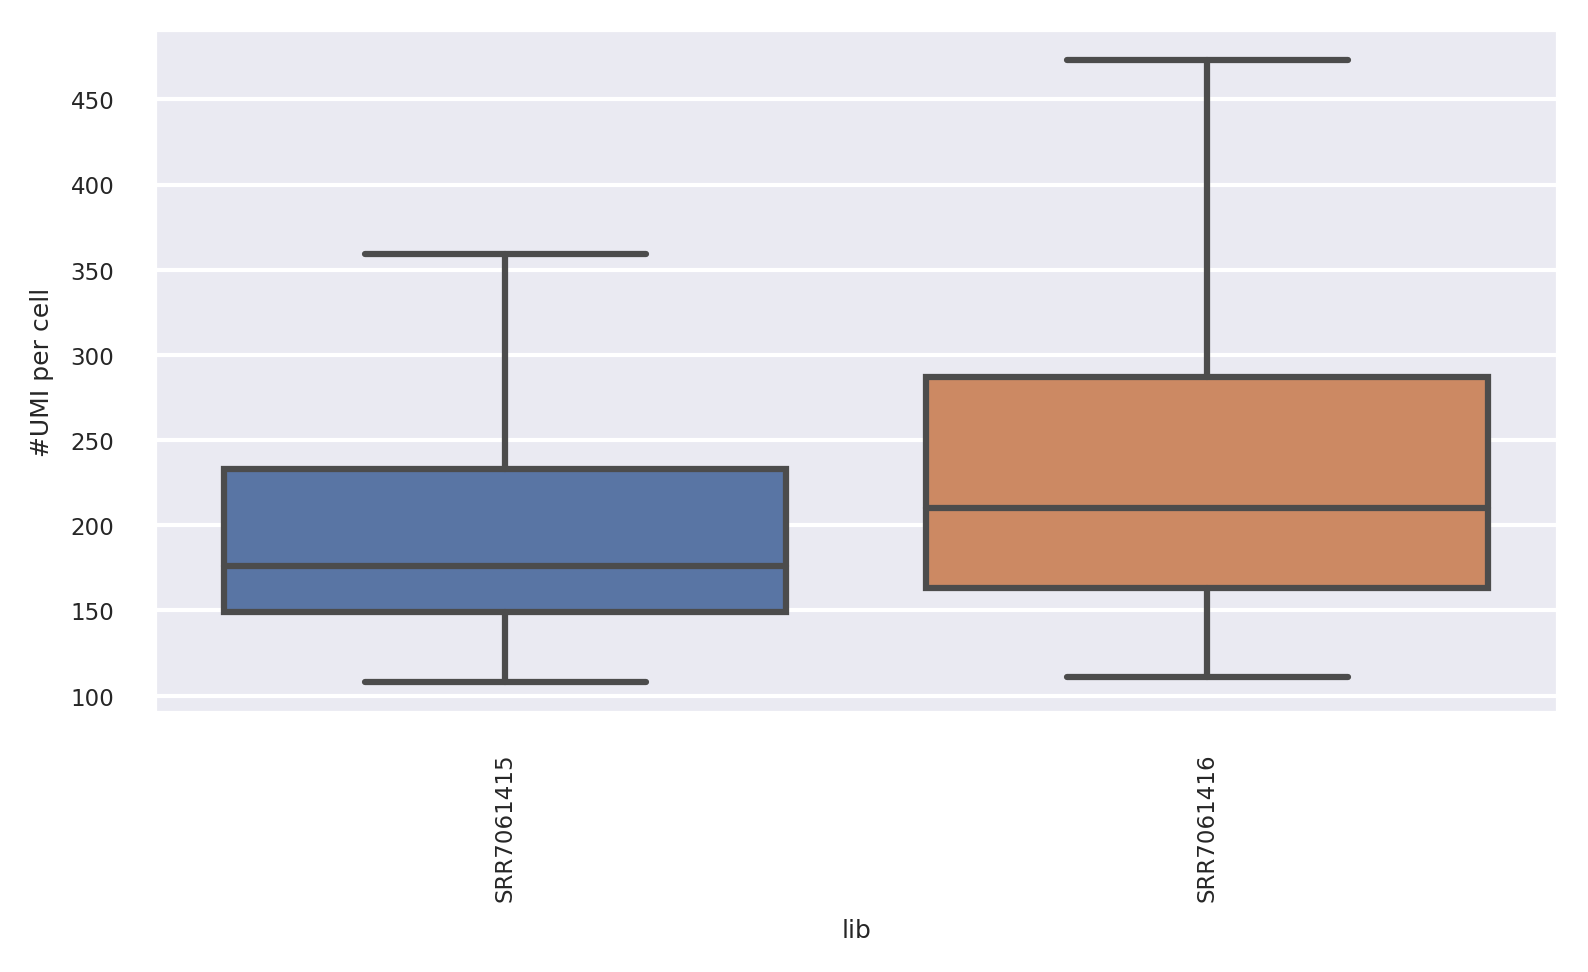

In [15]:
fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(adata.obs, x="lib", y="nUMI_per_cell", showfliers=False)
plt.ylabel("#UMI per cell")
_ = plt.xticks(rotation=90)

In [16]:
# noggin
adata[:,"XBXT10g016721"].X.sum()

19.0

# Save raw counts

In [18]:
DATA_DIR = "/n/groups/kirschner/xenopus/old_atlas"

In [19]:
adata_fp = os.path.join(DATA_DIR, "adata", "raw_counts", f"{version}.{NF_stage}.realigned.h5ad")
if not os.path.exists(os.path.dirname(adata_fp)):
    os.makedirs(os.path.dirname(adata_fp))
adata.write(adata_fp)

# SoupX

In [20]:
# %%R
# install.packages('SoupX')

In [21]:
# import rpy2.robjects as robjects
# r=robjects.r
# r.source('../little.R')

In [22]:
# from rpy2.robjects import numpy2ri, pandas2ri, default_converter
# from rpy2.robjects.conversion import localconverter
# import anndata as ad
# from scipy.io import mmwrite
# import logging
# import anndata2ri

# import rpy2.rinterface_lib.callbacks as rcb
# import rpy2.robjects as ro

# rcb.logger.setLevel(logging.ERROR)
# ro.pandas2ri.activate()
# anndata2ri.activate()

In [23]:
# # checkpoint
# for lib_name, adata_batch in zip(lib_names, adatas):
#     adata_batch.raw = adata_batch

In [24]:
# # checkpoint restore
# for adata_batch, lib_name in zip(adatas, libs):
#     adata_batch = adata_batch.raw.to_adata()

In [25]:
# sc.pp.highly_variable_genes(adata_batch, flavor="seurat_v3", n_top_genes=3000)
# sc.pp.normalize_total(adata_batch, target_sum=5000)
# sc.pp.scale(adata_batch, max_value=10, zero_center=False)
# sc.pp.pca(adata_batch, n_comps=30)

In [26]:
# excepted = []
# libs_corrected = []
# adata_corrected = []
# res = 1
# leiden_key = f"leiden_{res}"

# for lib_name, adata_batch in zip(lib_names, adatas):
#     print("###################################")
#     print(lib_name)
#     try:
#         # clusterization
#         adata_t = adata_batch.copy()
#         sc.experimental.pp.recipe_pearson_residuals(adata_t, theta=10, n_top_genes=3000)
#         sc.pp.neighbors(adata_t, n_neighbors=15, n_pcs=20)
#         sc.tl.leiden(adata_t, resolution=res, key_added=leiden_key)
#         # run SoupX
#         cells = adata_batch.obs_names
#         genes = adata_batch.var_names
#         data = adata_batch.X.T
#         soupx_groups = adata_t.obs[leiden_key]
#         mmwrite('temp.mtx', data)

#         with localconverter(
#             default_converter + numpy2ri.converter + pandas2ri.converter + anndata2ri.converter
#         ) as cv:
#             out = r.run_SoupX(genes, cells, soupx_groups)
        
#         adata_batch_cor = ad.AnnData(out.T)
#         adata_batch_cor.obs_names = adata_batch.obs_names
#         adata_batch_cor.var_names = adata_batch.var_names
#         for layer in layers:
#             adata_batch_cor.layers[layer] = adata_batch.layers[layer]
            
#         libs_corrected.append(lib_name)
#         adata_corrected.append(adata_batch_cor)
    
#     except Exception as ex:
#         print(f"!!! SAMPLE {lib_name} failed: ", ex)
#         excepted.append(lib_name)

In [27]:
# excepted

In [28]:
# adata = ad.concat(
#     adata_corrected,
#     axis=0,
#     join="outer",
#     label="lib",
#     keys=libs_corrected
# )

## gene names

In [16]:
REF_DIR = "/n/groups/kirschner/xenopus/reference/Xentr10.0"

gtf_ids = pd.read_csv(os.path.join(REF_DIR, "XENTR_10.0_Xenbase.names.tsv"), sep="\t")
gtf_ids[["eval_forward", "eval_backward"]] = gtf_ids[["eval_forward", "eval_backward"]].astype(float)
gtf_ids_unique = gtf_ids.sort_values("eval_forward").drop_duplicates("gene_id")
cols = ["gene_name", "human_id", "human_name", "human_desc", "eval_forward", "eval_backward"]
adata.var[cols] = gtf_ids_unique.set_index("gene_id").loc[adata.var_names, cols].values
adata.var[["eval_forward", "eval_backward"]] = adata.var[["eval_forward", "eval_backward"]].astype(float)

```
SRR7061415
1247.0
797.0
18.0
4.0

SRR7061416
1599.0
874.0
4.0
0.0
```

In [17]:
for gene in ["ddx25", "dazl", "sybu", "dnd1"]:
    x = 0
    for layer, counts in adata.layers.items():
        x_l = counts[:,adata.var.gene_name==gene].sum()
        print(f"{gene}\t{layer}\t{x_l}")
        x += x_l
    print(f"{gene}\tX\t{adata[:,adata.var.gene_name==gene].X.sum()}\t{x}")

ddx25	intron	53.0
ddx25	exon	1779.0
ddx25	spanning	2.0
ddx25	X	1834.0	1834.0
dazl	intron	655.0
dazl	exon	749.0
dazl	spanning	116.0
dazl	X	1520.0	1520.0
sybu	intron	12.0
sybu	exon	1088.0
sybu	spanning	0.0
sybu	X	1104.0	1100.0
dnd1	intron	22.0
dnd1	exon	1671.0
dnd1	spanning	4.0
dnd1	X	2846.0	1697.0


In [18]:
for gene in ["ddx25", "dazl", "sybu", "dnd1"]:
    x = 0
    # for layer, counts in adata.layers.items():
    #     x_l = counts[:,adata.var.gene_name==gene].sum()
    #     print(f"{gene}\t{layer}\t{x_l}")
    #     x += x_l
    print(f"{gene}\tX\t{adata[:,adata.var.gene_name==gene].X.sum()}\t{x}")

ddx25	X	2179.0	0
dazl	X	1648.0	0
sybu	X	1107.0	0
dnd1	X	2205.0	0


In [30]:
# adata.var["n_cells"] = ((adata.layers["exon"] + adata.layers["spanning"]) > 0).sum(axis=0).A1
# adata.obs["nUMI_per_cell"] = (adata.layers["exon"] + adata.layers["spanning"]).sum(axis=1)
# adata.obs["ngenes_per_cell"] = ((adata.layers["exon"] + adata.layers["spanning"]) > 0).sum(axis=1)

In [31]:
adata.write(os.path.join(DATA_DIR, "adata", f"{version}.{NF_stage}.realigned.corrected.h5ad"))

# Filter

In [32]:
adata.var["n_cells"] = (adata.X > 0).sum(axis=0).A1
adata.obs["nUMI_per_cell"] = adata.X.sum(axis=1)
adata.obs["ngenes_per_cell"] = (adata.X > 0).sum(axis=1)

In [33]:
(adata.var.n_cells < 3).sum()

1335

In [34]:
adata = adata[:, adata.var.n_cells >= 3]

In [35]:
adata.obs.lib.value_counts()

lib
S22_2_5    63620
S22_2_7    57043
S22_2_4    55286
S22_2_6    54805
S22_1_4    19086
S22_1_5    15484
S22_1_7    13495
S22_2_2     8149
S22_2_3     8110
S22_1_6     7569
S22_2_1     7379
S22_1_3     5222
S22_1_2     5036
S22_1_1     4552
Name: count, dtype: int64

In [36]:
nUMI_per_cell = 150
ngenes_per_cell = 100
adata = adata[(adata.obs.nUMI_per_cell > nUMI_per_cell) & (adata.obs.ngenes_per_cell > ngenes_per_cell), :]

In [37]:
adata.obs.lib.value_counts()

lib
S22_2_5    56562
S22_2_7    50979
S22_2_6    49817
S22_2_4    49521
S22_1_4    11005
S22_1_5     9049
S22_1_7     7661
S22_2_3     6700
S22_2_2     6597
S22_2_1     5755
S22_1_6     4443
S22_1_2     4027
S22_1_3     3961
S22_1_1     3604
Name: count, dtype: int64

## mean vs var

In [38]:
# from scipy.optimize import curve_fit
# fit_NB = True
# log = True
# xlim = None # [0, 50]
# ylim = None # [0, 50]

In [39]:
# means = adatas[0].X.mean(axis=0).A1
# centered = adatas[0].X.A - means
# variances = (centered**2).sum(axis=0) / centered.shape[0]

# means = means[variances > 0]
# variances = variances[variances > 0]

# lim_min = min(np.min(means), np.min(variances))
# lim_max = max(np.max(means), np.max(variances))

In [40]:
# def f_NB(x, a):
#     return x + a * x**2

# fig, ax = plt.subplots(figsize=(4, 4))

# ax.plot([lim_min - 0.5, lim_max + 0.5], [lim_min - 0.5, lim_max + 0.5],
#       linewidth=1, color="grey", label="$Var(E) = E$")
# sns.scatterplot(x=means, y=variances, ax=ax, linewidth=0, s=3)

# if fit_NB:
#     popt_NB, _ = curve_fit(f_NB, means, variances)
#     fit_line_NB = np.array(range(int(lim_max))) * 0.01
#     ax.plot(fit_line_NB, f_NB(fit_line_NB, *popt_NB), color="red", 
#             label="$Var(E) = E + ${:.2f}$E^2$".format(popt_NB[0]))
#     ax.set_ylabel("Variance")
#     ax.set_xlabel("Mean")
# if log:
#     ax.set_xscale("log")
#     ax.set_yscale("log")

# if not(xlim is None):
#     ax.set_xlim(left=xlim[0], right=xlim[1])
# else:
#     ax.set_xlim(left=0, right=lim_max)

# if not(ylim is None):
#     ax.set_ylim(bottom=ylim[0], top=ylim[1])
# else:
#     ax.set_ylim(bottom=0, top=lim_max)

# ax.legend()

# Visualize

In [41]:
adata.obs["lib"] = adata.obs.lib.astype("category")

/tmp/ipykernel_9782/716970556.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["lib"] = adata.obs.lib.astype("category")
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


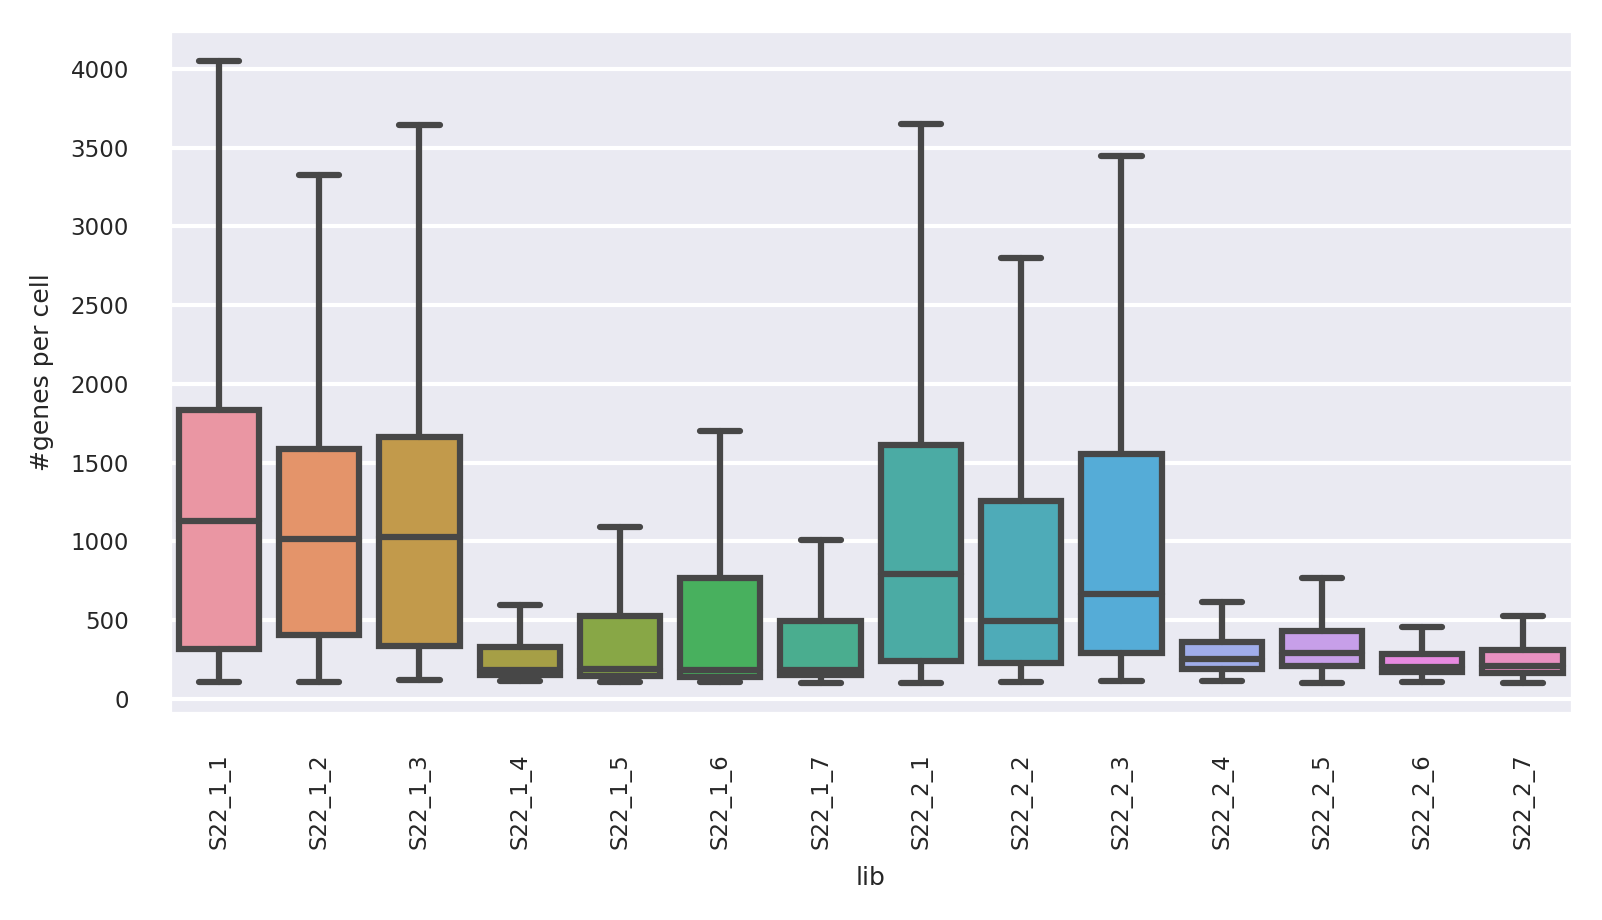

In [42]:
fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(adata.obs, x="lib", y="ngenes_per_cell", showfliers=False)
plt.ylabel("#genes per cell")
_ = plt.xticks(rotation=90)

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


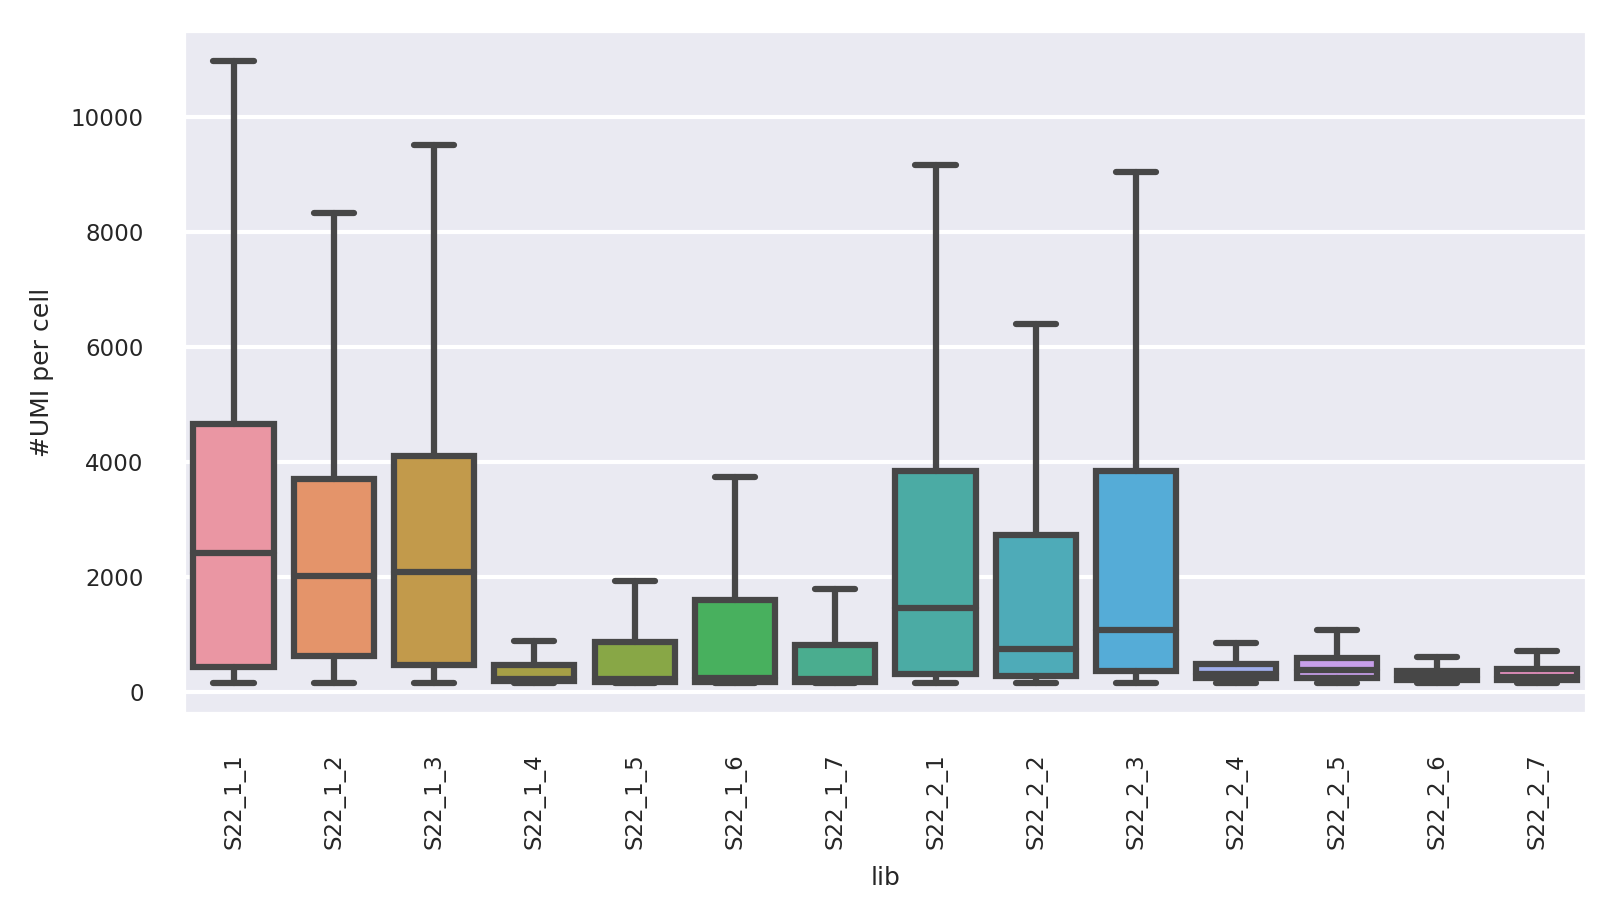

In [43]:
fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(adata.obs, x="lib", y="nUMI_per_cell", showfliers=False)
plt.ylabel("#UMI per cell")
_ = plt.xticks(rotation=90)

In [44]:
adata.obs_names_make_unique()

In [45]:
n_pcs = 20
sc.experimental.pp.recipe_pearson_residuals(adata, n_top_genes=3000, theta=10, batch_key="lib", n_comps=n_pcs)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
computing analytic Pearson residuals on adata.X
    finished (0:00:26)
computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:49)


/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


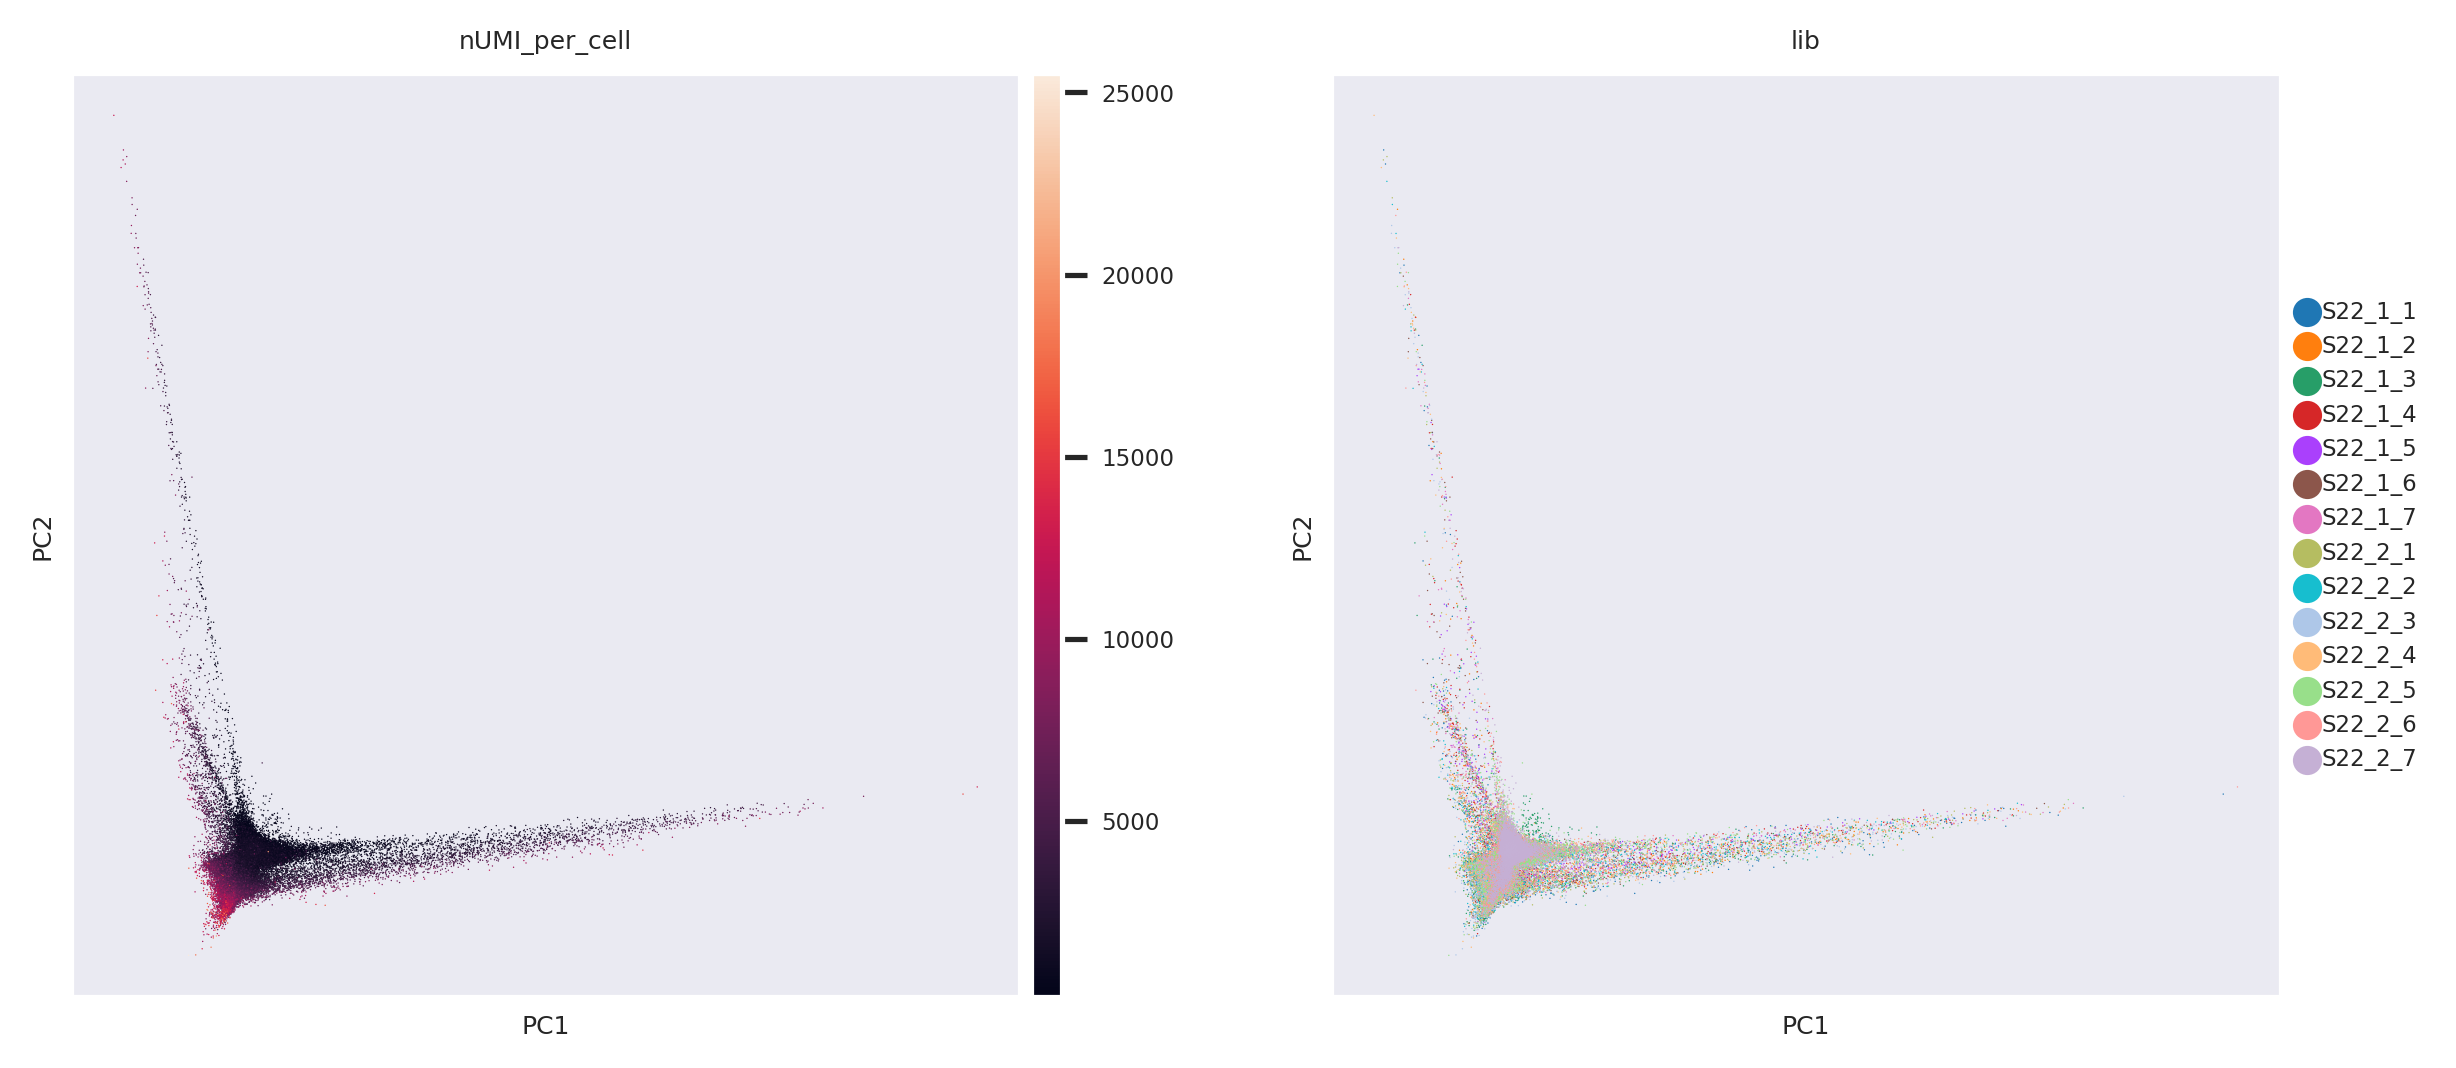

In [46]:
sc.pl.pca(adata, color=["nUMI_per_cell", "lib"])

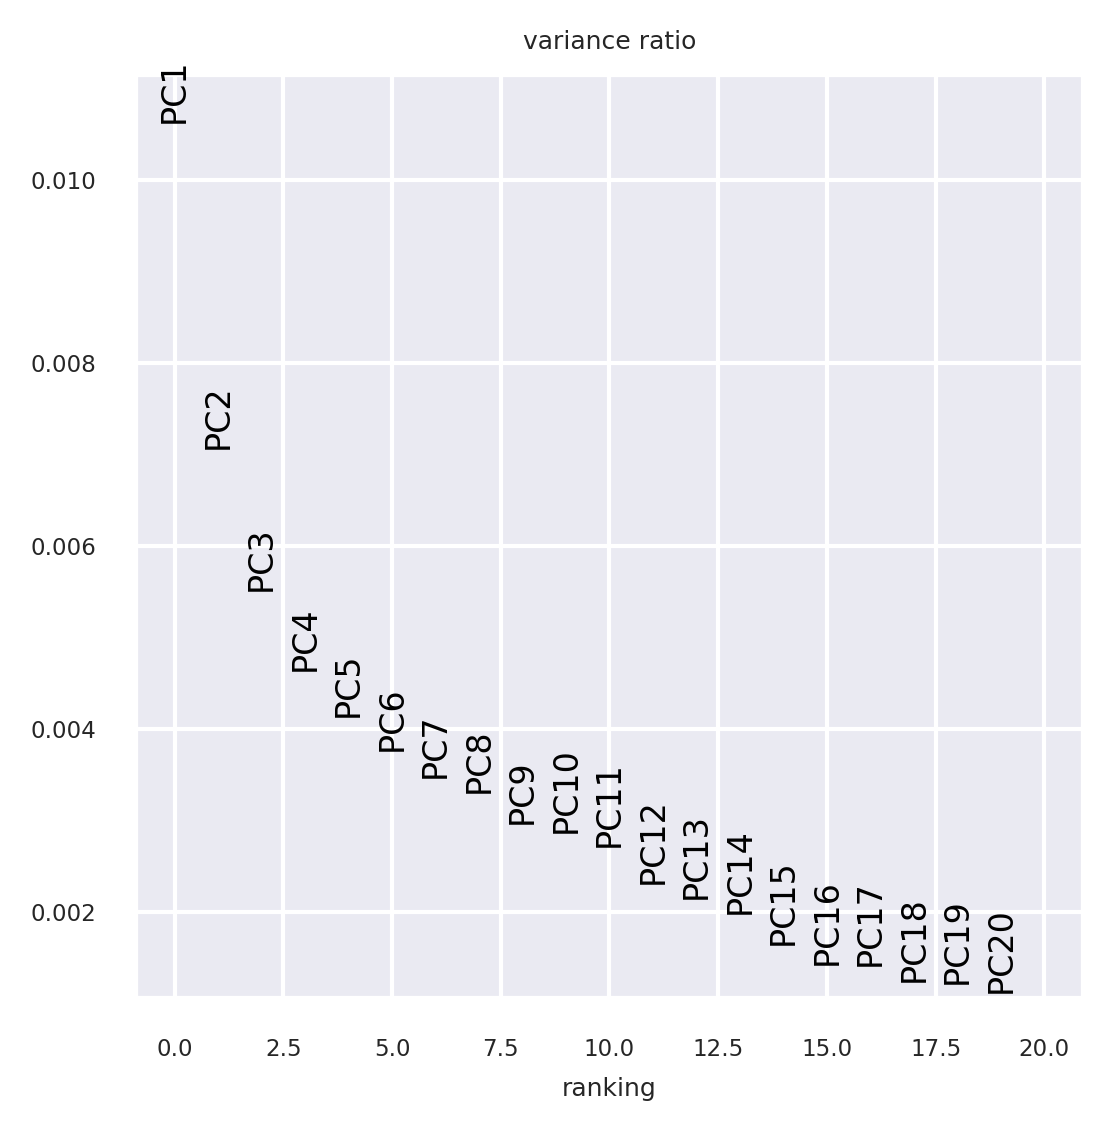

In [47]:
sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs)

In [48]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20


2024-10-28 15:30:43.934131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2024-10-28 15:30:43.934168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:07:15)


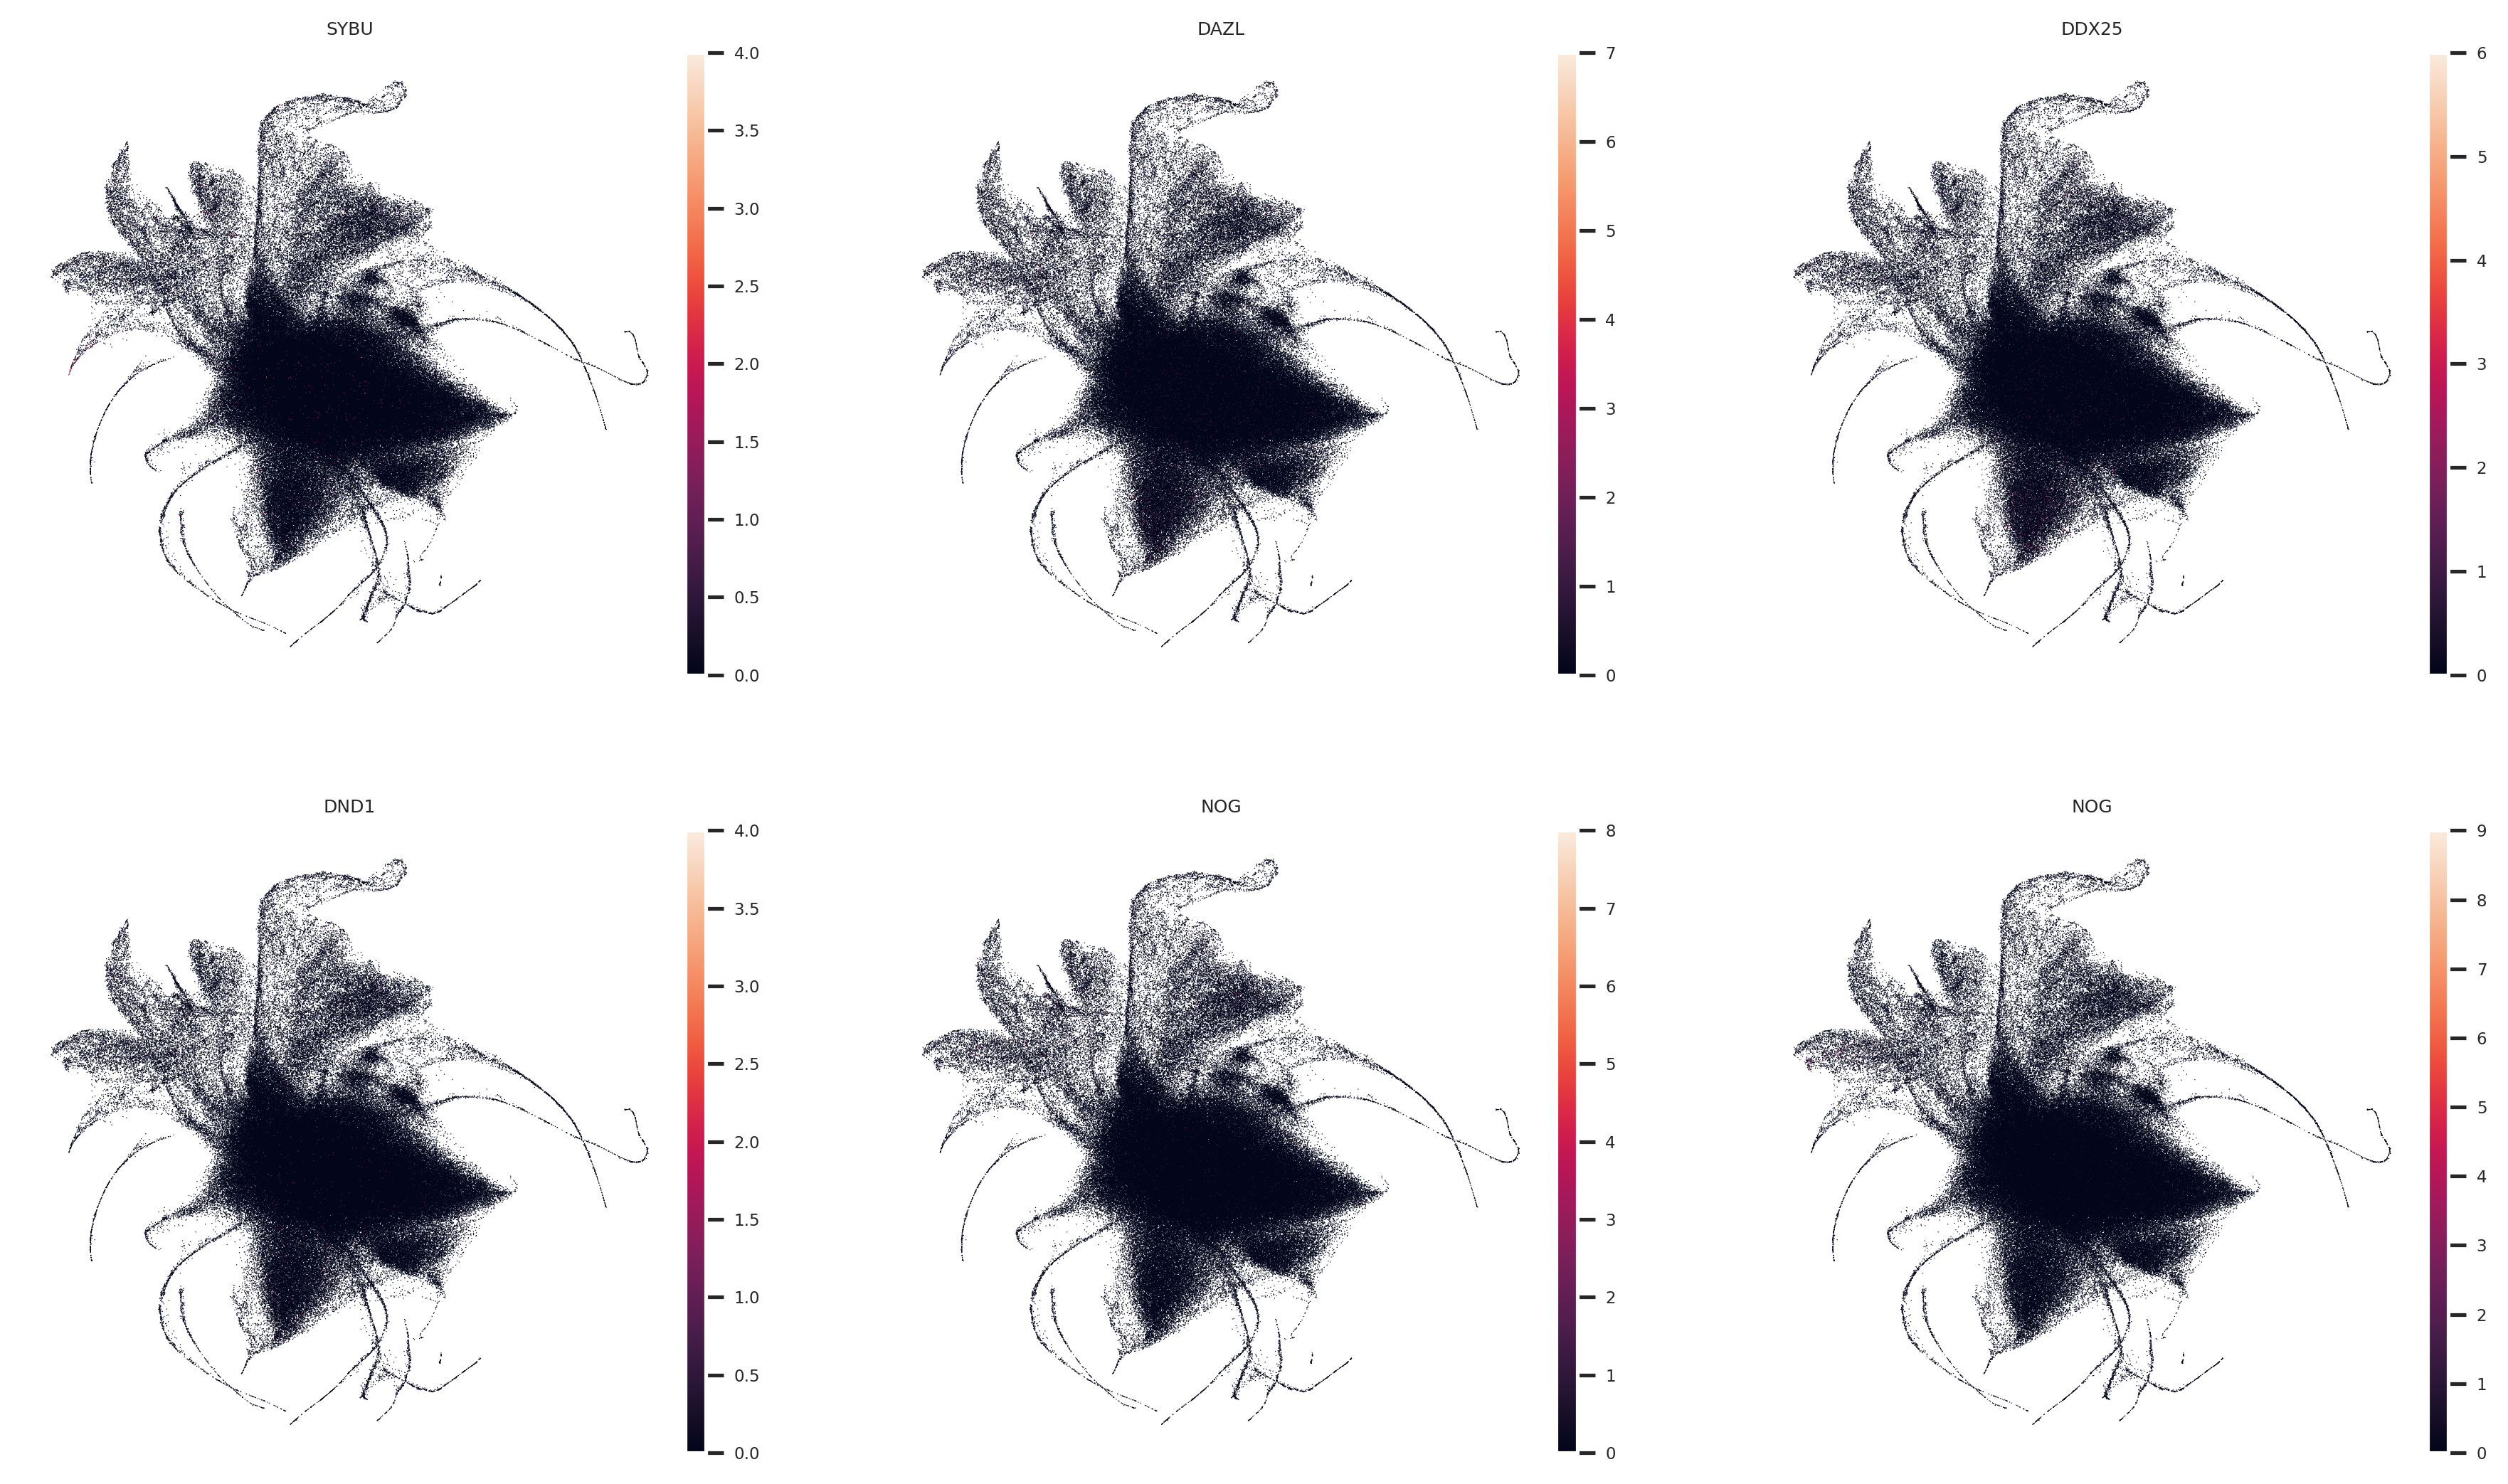

In [49]:
genes = ["ddx25", "dazl", "sybu", "dnd1", "nog", "nog2"]
color = adata.var_names[adata.var["gene_name"].isin(genes)]
names = adata.var.loc[adata.var["gene_name"].isin(genes), "human_name"]
sc.pl.umap(adata, color=color, frameon=False, ncols=3, use_raw=False, title=names)

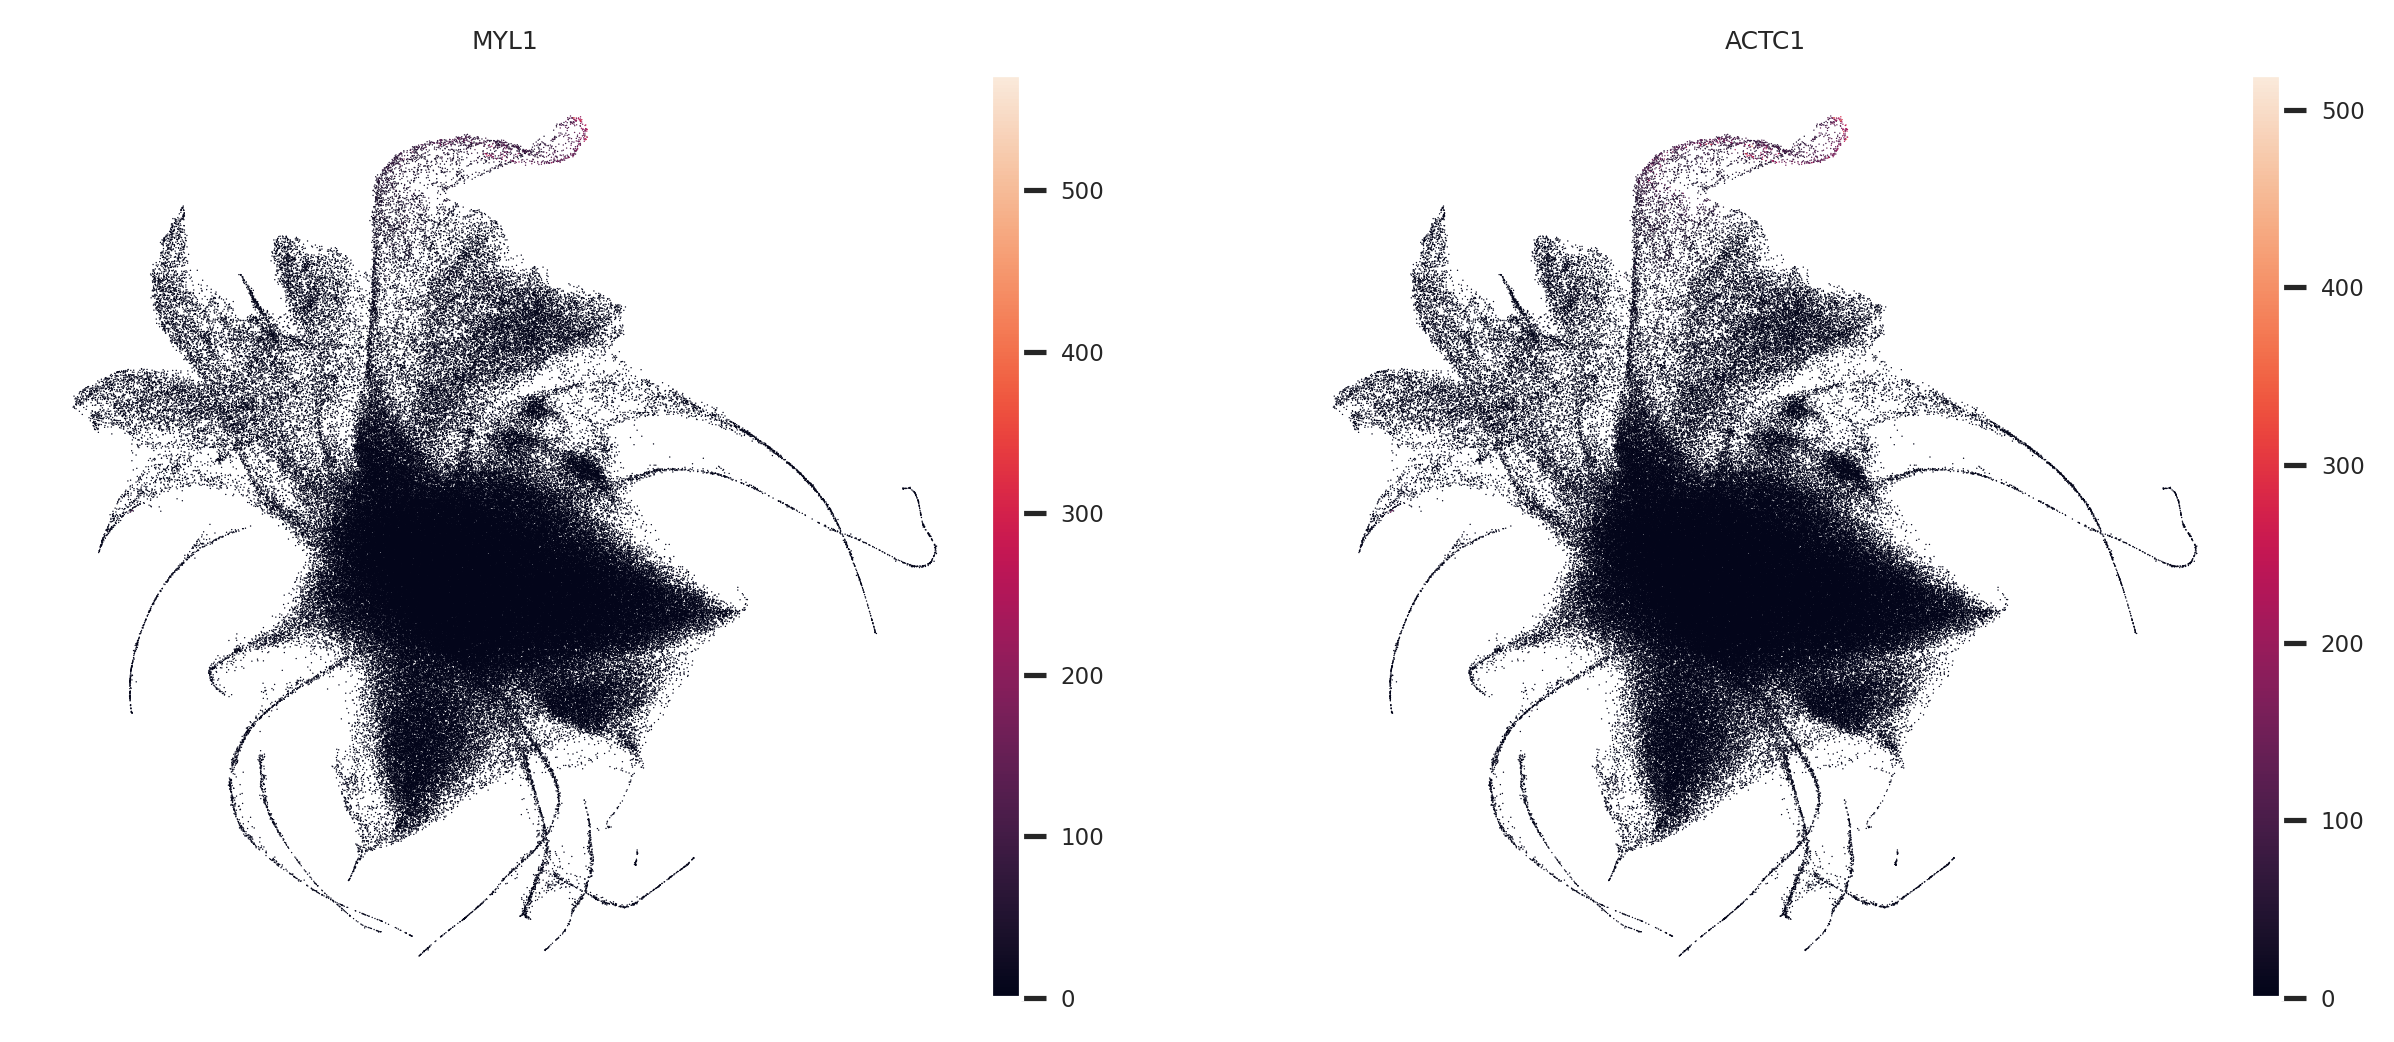

In [50]:
genes = ["actc1", "myl1", "mylpf"]
color = list(adata.var_names[adata.var["gene_name"].isin(genes)])
names = list(adata.var.loc[adata.var["gene_name"].isin(genes), "human_name"])
sc.pl.umap(adata, color=color, frameon=False, ncols=2, use_raw=False, title=names)